In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, \
    RobustScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [4]:
def score_model(model, X, Y):
    
    scores = cross_validate(
        model, X, Y, 
        scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv=2,
        n_jobs=-1, verbose=0)

    rmsle_score = cross_val_score(model, X, Y, cv=2, scoring=make_scorer(neg_rmsle))

    mse_score = -1 * scores['test_neg_mean_squared_error'].mean()
    mse_std = scores['test_neg_mean_squared_error'].std()

    mae_score = -1 * scores['test_neg_mean_absolute_error'].mean()
    mae_std = scores['test_neg_mean_absolute_error'].std()

    r2_score_mean = scores['test_r2'].mean()
    r2_std = scores['test_r2'].std()

    print('[CV] MSE: %.4f (%.4f)' % (mse_score, mse_std))
    print('[CV] MAE: %.4f (%.4f)' % (mae_score, mae_std))
    print('[CV] R^2: %.4f (%.4f)' % (r2_score_mean, r2_std))
    print('[CV] RMSLE: %.6f (%.4f)' % (rmsle_score.mean(), rmsle_score.std()))

In [5]:
np.random.seed(42)
set_config(display='diagram')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [6]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [7]:
num_features = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
num_features.remove('Id')
num_features.remove('SalePrice')

cat_features = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

In [8]:
for feature in (
    'PoolQC', 
    'FireplaceQu', 
    'Alley', 
    'Fence', 
    'MiscFeature', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond',
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'MasVnrType',
    'MSSubClass',
):
    train_df[feature] = train_df[feature].fillna('None')
    test_df[feature] = test_df[feature].fillna('None')

for feature in (
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath',
    'MasVnrArea',
    'GarageCars',
    'GarageArea',
    'GarageYrBlt',
):
    train_df[feature] = train_df[feature].fillna(0)
    test_df[feature] = test_df[feature].fillna(0)

for feature in (
    'Electrical', 
    'KitchenQual', 
    'Exterior1st',
    'Exterior2nd', 
    'SaleType',
    'MSZoning',
    'Utilities',
):
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])

train_df['Functional'] = train_df['Functional'].fillna('Typical')
test_df['Functional'] = test_df['Functional'].fillna('Typical')

In [9]:
# Remove outliers
train_df.drop(
    train_df[(train_df["GrLivArea"] > 4000) & (train_df["SalePrice"] < 700000)].index
);

In [10]:
ordinal_feature_mapping = {
    'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, 
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PoolQC': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Alley': {'None': 0, 'Pave': 1, 'Grvl': 2},
    'Street': {'Pave': 0, 'Grvl': 1},
}

non_ordinal_cat_features = list(set(cat_features) - set(ordinal_feature_mapping.keys()))

for cat_feature in non_ordinal_cat_features:
    train_df[cat_feature + 'Enc'] = LabelEncoder().fit_transform(train_df[cat_feature])
    test_df[cat_feature + 'Enc'] = LabelEncoder().fit_transform(test_df[cat_feature])

for ordinal_feature, feature_mapping in ordinal_feature_mapping.items():
    train_df[ordinal_feature + 'Enc'] = train_df[ordinal_feature].map(feature_mapping)
    test_df[ordinal_feature + 'Enc'] = test_df[ordinal_feature].map(feature_mapping)

In [11]:
def neg_rmsle(y_true, y_pred):
    return -1 * np.sqrt(mean_squared_log_error(y_true, y_pred))

In [12]:
baselineFeatures = [
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtUnfSF',
    'OverallQual',
    'GarageCars', 
    'OverallCond', 
    'Neighborhood', 
    'MSSubClass', 
    'LotShape',
    'LandSlope',
    'BsmtCondEnc',
    'BsmtQualEnc',
]

X = train_df[baselineFeatures]
Y = train_df['SalePrice']

In [13]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.3, random_state=42)

In [14]:
subclassCategories = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]
basementFinishCategories = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
neighborhoodCategories = train_df['Neighborhood'].unique()
lotConfigCategories = train_df['LotConfig'].unique()
lotShapeCategories = train_df['LotShape'].unique()
landSlopeCategories = train_df['LandSlope'].unique()

In [15]:
# Build feature transformer

logTransformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

basementCondTransformer = Pipeline([
    ('basement_condition_impute', SimpleImputer(strategy="constant", fill_value='None')),
    ('basement_condition_onehot', OneHotEncoder()),
])

basementAreaTransformer = Pipeline([
    ('basement_area_impute', SimpleImputer(strategy="constant", fill_value=0)),
    ('basement_area_log', logTransformer),
])

featureTransformer = ColumnTransformer([
        ('basement_area_transformer', basementAreaTransformer, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']),
        ('neighborhood_onehot', OneHotEncoder(categories=[neighborhoodCategories]), ['Neighborhood']),
        ('subclass_onehot', OneHotEncoder(categories=[subclassCategories]), ['MSSubClass']),
        ('lot_shape_onehot', OneHotEncoder(categories=[lotShapeCategories]), ['LotShape']),
        ('land_slope_onehot', OneHotEncoder(categories=[landSlopeCategories]), ['LandSlope']),
    ],
    remainder='passthrough'
)

In [16]:
linRegrPipeline = Pipeline([
    ("preprocessing", featureTransformer),
    ("regression", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)),
])

linRegrPipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('basement_area_transformer',
                                                  Pipeline(steps=[('basement_area_impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('basement_area_log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF']),
                                                 ('neighbo...
                                                  ['MSSubClass']),
                                                 ('lot_shape_onehot',
                                                  OneHotEncoder(categories=[array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)]),
                                                  ['LotShape']),
                                                 ('land_slope_onehot',
                                                  OneHotEncoder(categories=[array(['Gtl', 'Mod', 'Sev'], dtype=object)]),
                                                  ['LandSlope'])])),
                ('regression',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [17]:
linRegrPipeline.fit(X_train, y_train)

y_train_predicted = linRegrPipeline.predict(X_train)
y_validation_predicted_lr = linRegrPipeline.predict(X_validation)

print('[Train] MSE: %.2f' % mean_squared_error(y_train, y_train_predicted))
print('[Train] MAE: %.2f' % mean_absolute_error(y_train, y_train_predicted))
print('[Train] R^2: %.2f' % r2_score(y_train, y_train_predicted))

print('[Test] MSE: %.2f' % mean_squared_error(y_validation, y_validation_predicted_lr))
print('[Test] MAE: %.2f' % mean_absolute_error(y_validation, y_validation_predicted_lr))
print('[Test] R^2: %.2f' % r2_score(y_validation, y_validation_predicted_lr))

[Train] MSE: 968075726.05
[Train] MAE: 17216.91
[Train] R^2: 0.84
[Test] MSE: 628022688.54
[Test] MAE: 16837.35
[Test] R^2: 0.91


In [18]:
score_model(linRegrPipeline, X, Y)

# CV=6: MSE: 1417944709.38, MAE: 17956.26, R^2: 0.76
# CV=5: MSE: 1398586541.44, MAE: 17957.81, R^2: 0.78
# CV=4: MSE: 1312457856.75, MAE: 17934.16, R^2: 0.79
# CV=3: MSE: 1358452005.21, MAE: 18075.38, R^2: 0.78
# CV=2: MSE: 1174227509.88, MAE: 18218.52, R^2: 0.81

[CV] MSE: 1174227509.8811 (233097962.5585)
[CV] MAE: 18218.5151 (444.5369)
[CV] R^2: 0.8106 (0.0488)
[CV] RMSLE: -0.149140 (0.0011)


In [19]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X_train, y_train, cv, train_sizes=np.linspace(0.1, 1, 10)):
    plt.style.use('seaborn-darkgrid')
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, 
        scoring='neg_mean_squared_error',
        cv=cv, 
        n_jobs=-1, 
        train_sizes=train_sizes,
        shuffle=True,
        random_state=42
        )
    train_mean_scores = np.mean(train_scores, axis=1)
    test_mean_scores = np.mean(test_scores, axis=1)

    plt.title('Learning curve')
    plt.plot(train_sizes, train_mean_scores, 'y', label='Train Learning curve')
    plt.plot(train_sizes, test_mean_scores, 'b', label='Test Learning curve')
    plt.legend()

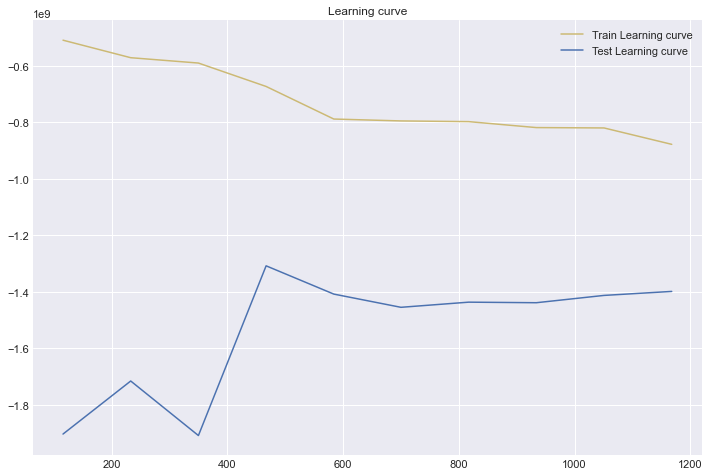

In [20]:
plot_learning_curve(linRegrPipeline, X, Y, cv=5)

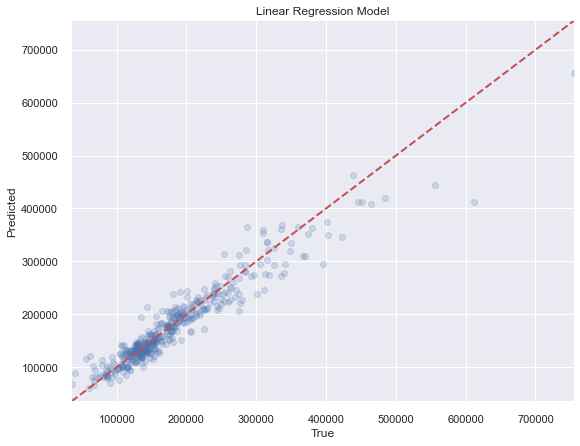

In [21]:
def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    ax.set_title(title)

fig, ax0 = plt.subplots(1, 1, figsize=(9, 7))

plot_regression_results(
    ax0, 
    y_true=y_validation, 
    y_pred=y_validation_predicted_lr, 
    title="Linear Regression Model"
)

In [22]:
# Fit model again on the whole training set before submition prediction
# 0.14288 is the best score this model gets

linRegrPipeline.fit(X, Y)

x_test = test_df[baselineFeatures]
y_test_predicted = linRegrPipeline.predict(x_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': y_test_predicted,
})

submission_df.to_csv('./data/submission_linear_regression.csv', index=False)